# trying different features for oxygen data

need to figure out what features actually help detect anomalies. just raw oxygen % probably not enough

ideas:
- rolling averages/std
- differences between consecutive readings
- how fast it's changing
- patterns like stuck values

let's try stuff and see what works

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../oxytrace/data/dataset.csv')
df['time'] = pd.to_datetime(df['time'], format='mixed')
df = df[df['Oxygen[%sat]'].notna()].copy()
df = df.sort_values('time').reset_index(drop=True)

# just look at first 10k rows for speed
df = df.iloc[:10000].copy()

print(f"loaded {len(df)} rows")
df.head()

loaded 10000 rows


,time,Oxygen[%sat],EquipmentUnit,SubUnit,System,Unit
0,2025-04-01 17:43:00,90.521339,EquipmentUnit_10,SubUnit_07,System_10,Unit_01
1,2025-04-01 17:43:00,91.639549,EquipmentUnit_05,NaN,System_10,Unit_01
2,2025-04-01 17:43:00,89.844864,EquipmentUnit_11,NaN,System_10,Unit_01
3,2025-04-01 17:43:00,91.377579,EquipmentUnit_10,SubUnit_08,System_10,Unit_01
4,2025-04-01 17:43:00,91.935204,EquipmentUnit_06,NaN,System_10,Unit_01


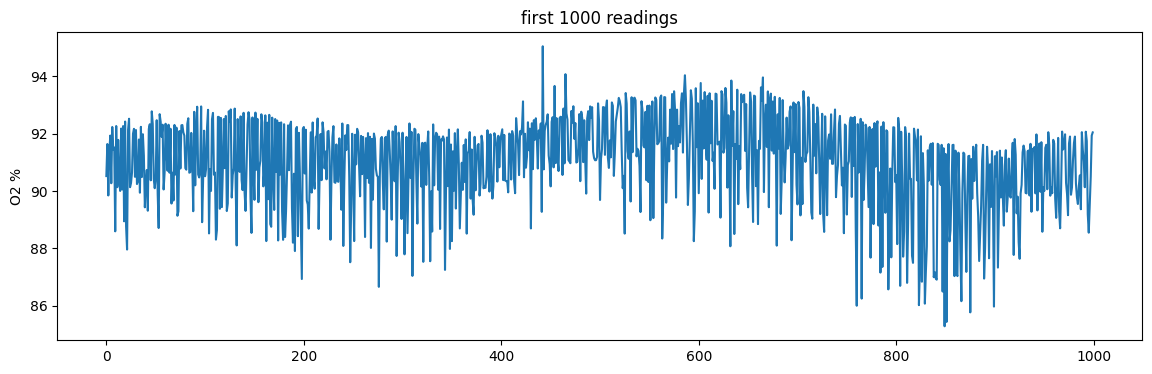

mean: 90.47
std: 2.18
min: 35.01
max: 101.45


In [2]:
# basic stats first
oxygen = df['Oxygen[%sat]'].values

plt.figure(figsize=(14, 4))
plt.plot(oxygen[:1000])
plt.title('first 1000 readings')
plt.ylabel('O2 %')
plt.show()

print(f"mean: {oxygen.mean():.2f}")
print(f"std: {oxygen.std():.2f}")
print(f"min: {oxygen.min():.2f}")
print(f"max: {oxygen.max():.2f}")

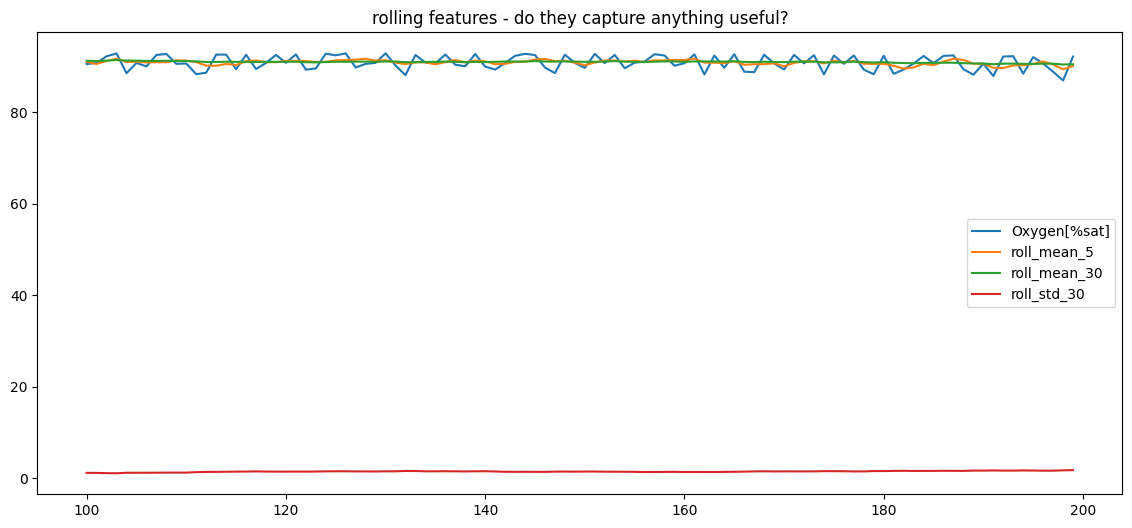

In [3]:
# try rolling window features - maybe anomalies deviate from recent average?
windows = [5, 10, 30, 60]

test_df = df.copy()
for w in windows:
    test_df[f'roll_mean_{w}'] = test_df['Oxygen[%sat]'].rolling(w, min_periods=1).mean()
    test_df[f'roll_std_{w}'] = test_df['Oxygen[%sat]'].rolling(w, min_periods=1).std()
    test_df[f'diff_from_mean_{w}'] = test_df['Oxygen[%sat]'] - test_df[f'roll_mean_{w}']

test_df[['Oxygen[%sat]', 'roll_mean_5', 'roll_mean_30', 'roll_std_30']].iloc[100:200].plot(figsize=(14, 6))
plt.title('rolling features - do they capture anything useful?')
plt.show()

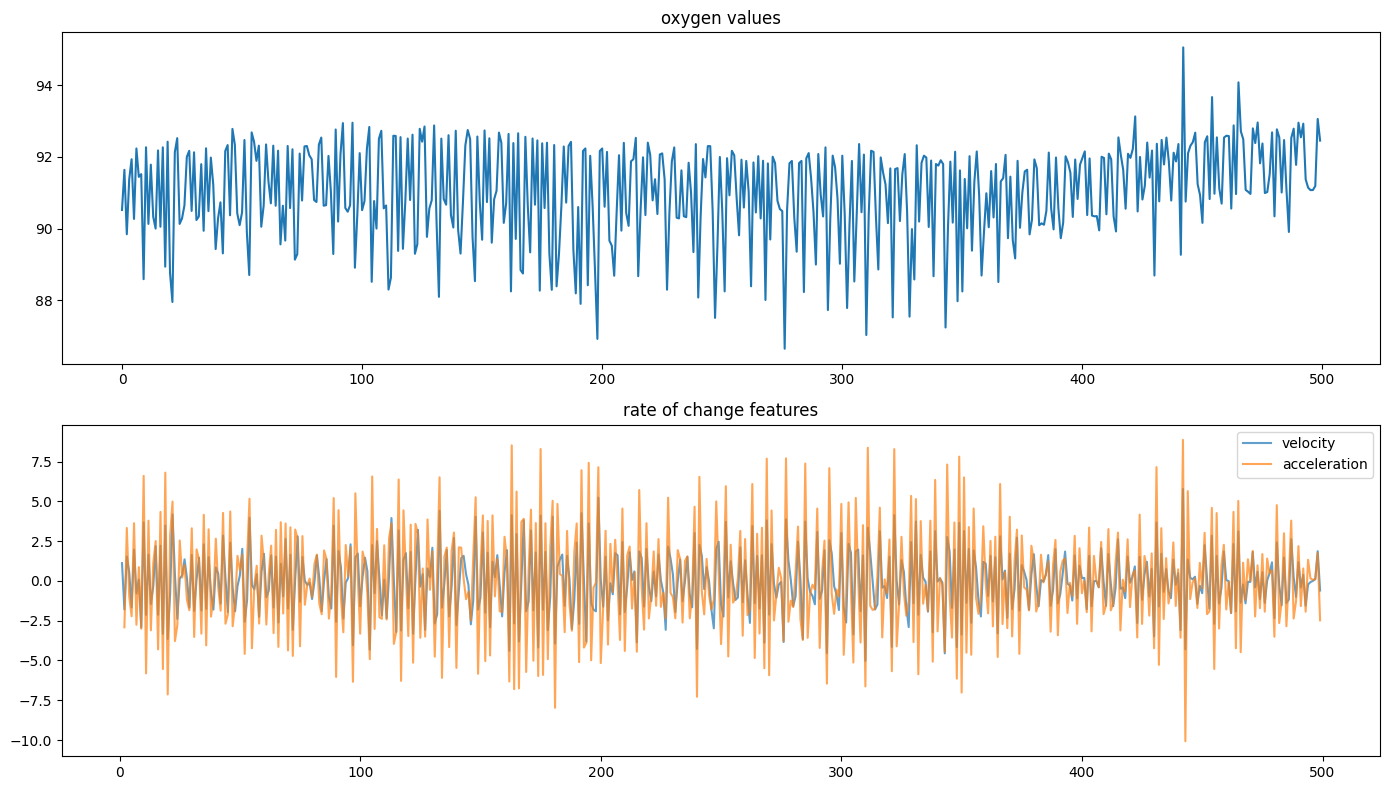

In [4]:
# what about rate of change? quick drops might be anomalies
test_df['diff_1'] = test_df['Oxygen[%sat]'].diff()
test_df['diff_5'] = test_df['Oxygen[%sat]'].diff(5)
test_df['diff_10'] = test_df['Oxygen[%sat]'].diff(10)

# velocity and acceleration
test_df['velocity'] = test_df['diff_1']
test_df['acceleration'] = test_df['diff_1'].diff()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(test_df['Oxygen[%sat]'].iloc[:500])
axes[0].set_title('oxygen values')
axes[1].plot(test_df['velocity'].iloc[:500], label='velocity', alpha=0.7)
axes[1].plot(test_df['acceleration'].iloc[:500], label='acceleration', alpha=0.7)
axes[1].legend()
axes[1].set_title('rate of change features')
plt.tight_layout()
plt.show()

# hmm acceleration seems noisy but velocity might be useful

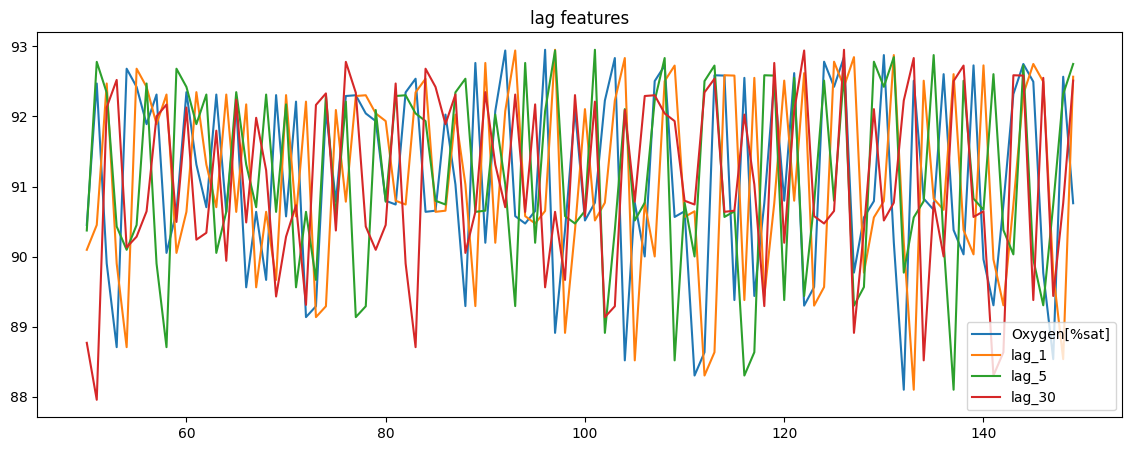

correlation with current O2:
  lag_1: 0.242
  lag_5: 0.335
  lag_10: 0.320
  lag_30: 0.282


In [5]:
# lag features - maybe previous values matter
for lag in [1, 5, 10, 30]:
    test_df[f'lag_{lag}'] = test_df['Oxygen[%sat]'].shift(lag)

test_df[['Oxygen[%sat]', 'lag_1', 'lag_5', 'lag_30']].iloc[50:150].plot(figsize=(14, 5))
plt.title('lag features')
plt.show()

# correlation with current value
print("correlation with current O2:")
for lag in [1, 5, 10, 30]:
    corr = test_df['Oxygen[%sat]'].corr(test_df[f'lag_{lag}'])
    print(f"  lag_{lag}: {corr:.3f}")

In [6]:
# stuck sensor detection - count consecutive same values
def count_consecutive_same(series):
    result = pd.Series(0, index=series.index)
    count = 0
    prev = None
    for i, val in enumerate(series):
        if val == prev:
            count += 1
        else:
            count = 0
        result.iloc[i] = count
        prev = val
    return result

test_df['consecutive_same'] = count_consecutive_same(test_df['Oxygen[%sat]'])

# check if there are stuck values
print(f"max consecutive same values: {test_df['consecutive_same'].max()}")
print(f"readings with >5 consecutive same: {(test_df['consecutive_same'] > 5).sum()}")

# plot some examples
stuck_idx = test_df[test_df['consecutive_same'] > 3].index
if len(stuck_idx) > 0:
    sample_idx = stuck_idx[0]
    window = test_df.iloc[max(0, sample_idx-50):sample_idx+50]
    plt.figure(figsize=(12, 4))
    plt.plot(window.index, window['Oxygen[%sat]'], marker='o')
    plt.axvline(sample_idx, color='r', linestyle='--', label='stuck detected')
    plt.legend()
    plt.title('example of stuck sensor detection')
    plt.show()

max consecutive same values: 1
readings with >5 consecutive same: 0


potential spikes detected: 273


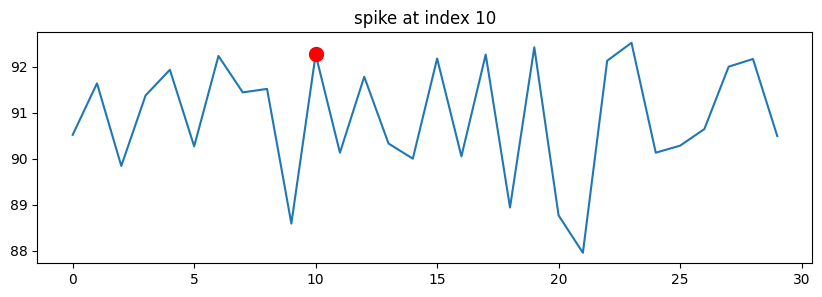

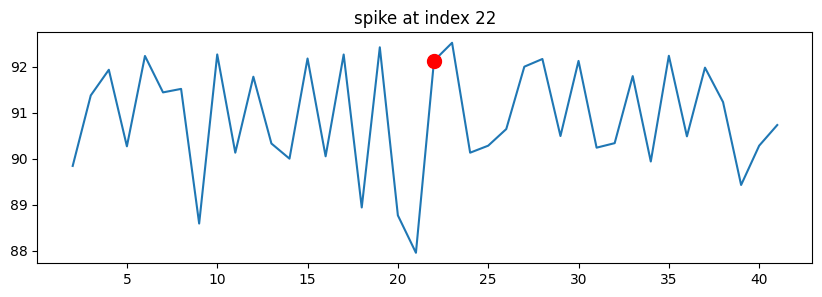

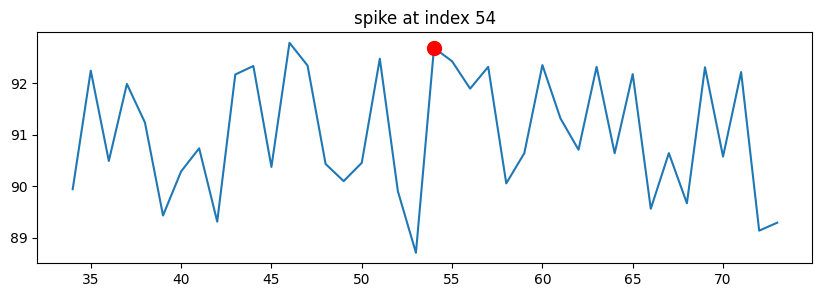

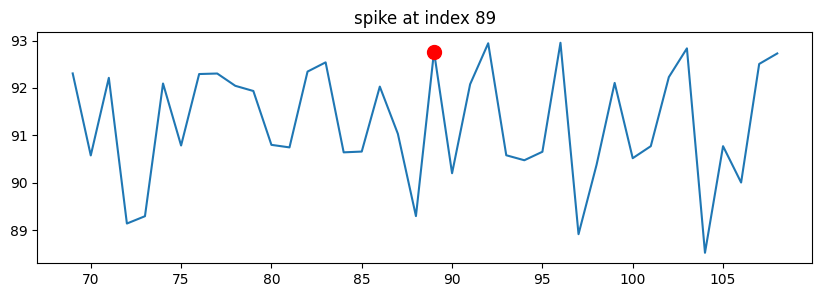

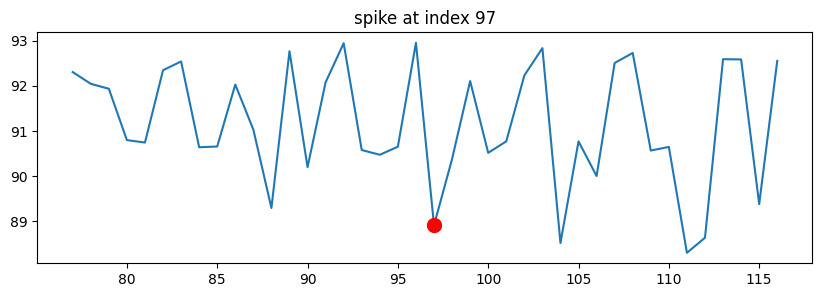

In [7]:
# spike detection - sudden changes
test_df['spike'] = np.abs(test_df['diff_1']) > (test_df['roll_std_30'] * 3)

print(f"potential spikes detected: {test_df['spike'].sum()}")

# visualize spikes
spike_idx = test_df[test_df['spike']].index[:5]  # first 5 spikes
for idx in spike_idx:
    window = test_df.iloc[max(0, idx-20):min(len(test_df), idx+20)]
    plt.figure(figsize=(10, 3))
    plt.plot(window.index, window['Oxygen[%sat]'])
    plt.scatter([idx], [test_df.loc[idx, 'Oxygen[%sat]']], color='red', s=100, zorder=5)
    plt.title(f'spike at index {idx}')
    plt.show()

In [8]:
# ok let's test with isolation forest to see which features actually help
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# create feature set
feature_cols = [
    'roll_mean_5', 'roll_mean_30', 'roll_std_5', 'roll_std_30',
    'diff_from_mean_5', 'diff_from_mean_30',
    'diff_1', 'diff_5', 'velocity', 'acceleration',
    'lag_1', 'lag_5', 'lag_30',
    'consecutive_same', 'spike'
]

# drop nulls
test_df_clean = test_df[['Oxygen[%sat]'] + feature_cols].dropna()
print(f"cleaned data: {len(test_df_clean)} rows")

# standardize
scaler = StandardScaler()
X = scaler.fit_transform(test_df_clean[feature_cols])

# fit isolation forest
iso = IsolationForest(contamination=0.05, random_state=42)
predictions = iso.fit_predict(X)
scores = iso.score_samples(X)

test_df_clean['anomaly'] = predictions
test_df_clean['anomaly_score'] = -scores  # negate so higher = more anomalous

print(f"\nanomalies detected: {(predictions == -1).sum()}")
print(f"score range: [{scores.min():.3f}, {scores.max():.3f}]")

cleaned data: 9970 rows

anomalies detected: 499
score range: [-0.798, -0.360]


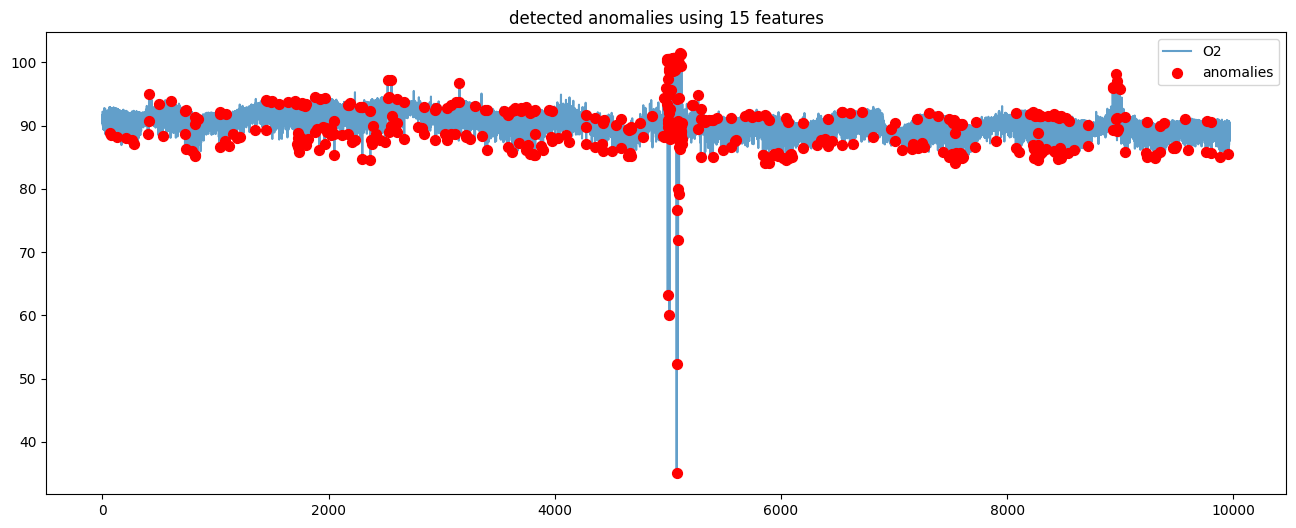

In [9]:
# visualize anomalies
plt.figure(figsize=(16, 6))
plt.plot(test_df_clean['Oxygen[%sat]'].values, label='O2', alpha=0.7)
anomaly_mask = test_df_clean['anomaly'] == -1
anomaly_indices = test_df_clean[anomaly_mask].index - test_df_clean.index[0]
plt.scatter(anomaly_indices, test_df_clean[anomaly_mask]['Oxygen[%sat]'].values, 
           color='red', s=50, label='anomalies', zorder=5)
plt.legend()
plt.title(f'detected anomalies using {len(feature_cols)} features')
plt.show()

# looks decent! but which features are most important?

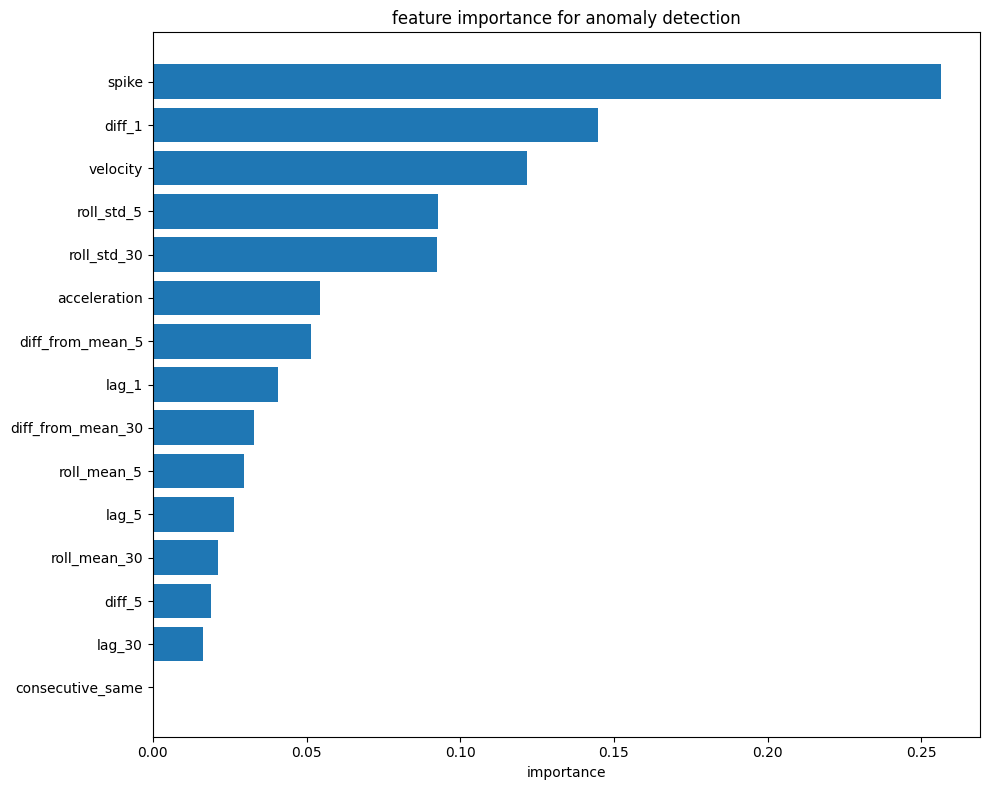


top 10 features:
              feature  importance
14              spike    0.256294
6              diff_1    0.144842
8            velocity    0.121838
2          roll_std_5    0.092716
3         roll_std_30    0.092349
9        acceleration    0.054506
4    diff_from_mean_5    0.051419
10              lag_1    0.040666
5   diff_from_mean_30    0.033037
0         roll_mean_5    0.029502


In [10]:
# feature importance using random forest (hack but works)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, predictions)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('importance')
plt.title('feature importance for anomaly detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\ntop 10 features:")
print(importance_df.head(10))

## notes for implementation

based on experiments:
1. rolling features (mean, std) at multiple windows are important - use 5, 10, 30, 60 min windows
2. rate of change features (diff, velocity, acceleration) help catch sudden drops
3. lag features provide context but only short lags (1, 5, 10) matter much
4. consecutive same value detection is good for stuck sensors
5. spike detection using 3*std threshold works

should probably add more windows and combinations. also consider:
- min/max in rolling windows
- range (max - min)
- percentiles?
- z-score relative to rolling mean

total features will be ~25ish. should be fine for isolation forest